In [1]:
import numpy as np
from scipy.optimize import minimize, LinearConstraint, NonlinearConstraint
import time
#from single_pendulum_task import single_pendulum_task as Task
from double_pendulum_task import double_pendulum_task as Task

%load_ext autoreload
%autoreload 2

In [2]:
task = Task()

### Basis functions. Providing Phi_T, Rw

Bernstein

In [3]:
def b(t, n, N):
    return np.math.factorial(N) / (np.math.factorial(n) * np.math.factorial(N-n)) * (task.T-t)**(N-n) * t**n

def get_Bernstein_basis(num_basis):
    factor = 10000
    t_array = np.linspace(0,task.T,int(task.T*factor))
    Phi_ = np.zeros((len(t_array), num_basis))
    for n in range(num_basis):
        Phi_[:,n] = b(t_array, n, num_basis-1)
    for k in range(len(t_array)):
        Phi_[k] /= np.sum(Phi_[k])
    
    dPhi_ = np.zeros((len(t_array)-1, num_basis))
    for k in range(len(t_array)-1):
        dPhi_[k] = (Phi_[k+1] - Phi_[k]) * factor

    ddPhi_ = np.zeros((len(t_array)-2, num_basis))
    for k in range(len(t_array)-2):
        ddPhi_[k] = (dPhi_[k+1] - dPhi_[k]) * factor

    ratio = len(t_array) / len(task.t_cost_array)
    Phi = np.zeros((len(task.t_cost_array), num_basis))
    dPhi = np.zeros((len(task.t_cost_array), num_basis))
    ddPhi = np.zeros((len(task.t_cost_array), num_basis))
    for k in range(1, len(task.t_cost_array)-1):
        k_ = int((k+0.5) * ratio)
        Phi[k] = Phi_[k_]
        dPhi[k] = dPhi_[k_]
        ddPhi[k] = ddPhi_[k_]
    Phi[0] = Phi_[0]
    dPhi[0] = dPhi_[0]
    ddPhi[0] = ddPhi_[0]
    Phi[-1] = Phi_[-1]
    dPhi[-1] = dPhi_[-1]
    ddPhi[-1] = ddPhi_[-1]
    
    return np.kron(Phi, np.eye(task.ndof)), np.kron(dPhi, np.eye(task.ndof)), np.kron(ddPhi, np.eye(task.ndof))

### Sequential least-squares quadratic programming

In [4]:
def fun(p):
    w = np.concatenate((task.q_0, p, task.q_d))
    return task.alpha_control * task.control_cost(w)

def torque_con_p(p):
    w = np.concatenate((task.q_0, p, task.q_d))
    return task.inverse_dynamics(w).flatten('F')

In [5]:
def run_opt(num_basis):
    nw = num_basis+2
    Phi, dPhi, ddPhi = get_Bernstein_basis(nw)

    task.set_basis(Phi, dPhi, ddPhi)

    Xi = np.zeros((nw*task.ndof, num_basis*task.ndof))
    Xi[task.ndof:-task.ndof] = np.eye(num_basis*task.ndof)

    def grad(p):
        w = np.concatenate((task.q_0, p, task.q_d))
        return (task.alpha_control * task.control_grad(w)) @ Xi

    K = len(task.t_cost_array)

    q_min = np.zeros(task.ndof*num_basis)
    q_max = np.zeros(task.ndof*num_basis)
    tau_lim = np.zeros(task.ndof*K)
    for i in range(task.ndof):
        q_min[i::task.ndof] = task.q_min[i] * np.ones(num_basis)
        q_max[i::task.ndof] = task.q_max[i] * np.ones(num_basis)
        tau_lim[i*K:(i+1)*K] = task.tau_lim[i] * np.ones(K)

    constraints = []
    dq_0_off = dPhi[:task.ndof, :task.ndof] @ task.q_0 + dPhi[:task.ndof, -task.ndof:] @ task.q_d
    constraints.append(LinearConstraint(dPhi[:task.ndof, task.ndof:-task.ndof],  -dq_0_off-1e-6, -dq_0_off+1e-6))
    dq_T_off = dPhi[-task.ndof:, :task.ndof] @ task.q_0 + dPhi[-task.ndof:, -task.ndof:] @ task.q_d
    constraints.append(LinearConstraint(dPhi[-task.ndof:, task.ndof:-task.ndof], -dq_T_off-1e-6, -dq_T_off+1e-6))
    constraints.append(LinearConstraint(np.eye(num_basis*task.ndof), q_min, q_max))
    constraints.append(NonlinearConstraint(torque_con_p, -tau_lim, tau_lim))

    p_init = np.zeros(num_basis*task.ndof)
    for i in range(num_basis):
        p_init[i*task.ndof:(i+1)*task.ndof] = task.q_0 + np.random.normal(0, 0, task.ndof)

    start = time.time()
    res = minimize(fun, p_init, method='SLSQP', jac=grad, bounds=None, constraints=constraints, options={'maxiter': 1000, 'ftol': 1e-6, 'disp': False})
    duration = time.time()-start
    print("Elapsed time: ", duration," [s]")
    return res.success, res.fun, np.concatenate((task.q_0, res.x, task.q_d)), duration

In [6]:
success = False
num_basis = 1
beta = 1.5
T = 0
while not success and num_basis < 200:
    print(num_basis)
    success, f, w_opt, duration = run_opt(num_basis)
    num_basis = int(np.ceil(num_basis*beta))
    T += duration

print(success, f, T)

1
Elapsed time:  0.9757804870605469  [s]
2
Elapsed time:  0.1881098747253418  [s]
3
Elapsed time:  0.7393069267272949  [s]
5
Elapsed time:  0.7842705249786377  [s]
8
Elapsed time:  0.9372375011444092  [s]
12
Elapsed time:  1.3694982528686523  [s]
18
Elapsed time:  1.5598032474517822  [s]
27
Elapsed time:  2.197230100631714  [s]
41
Elapsed time:  7.1713292598724365  [s]
62
Elapsed time:  52.57965850830078  [s]
True 12.501021098248197 68.5022246837616


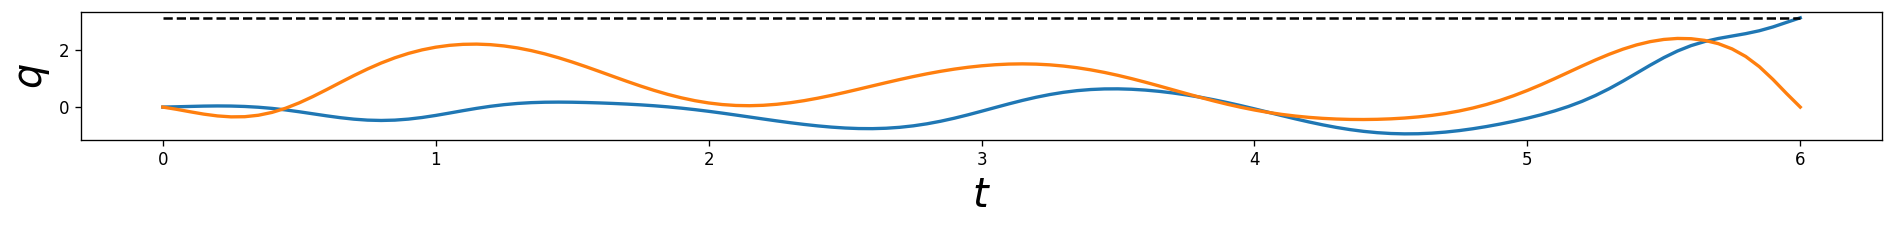

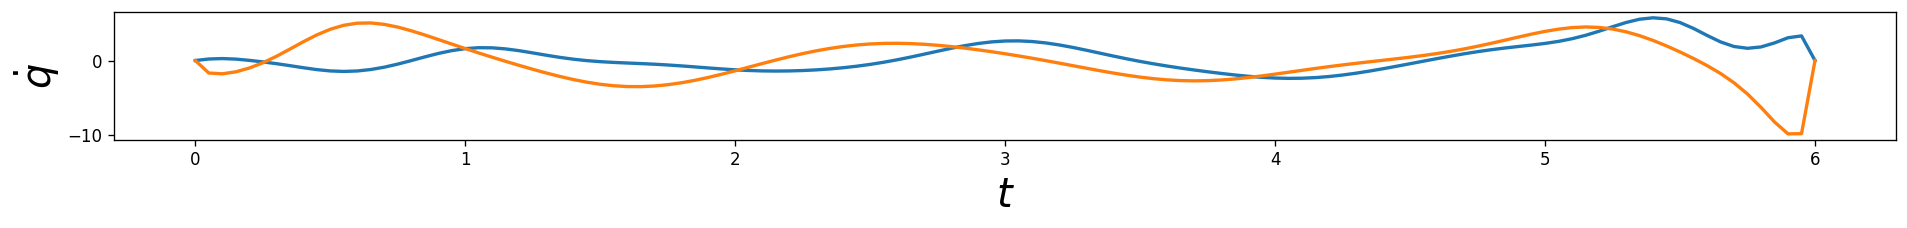

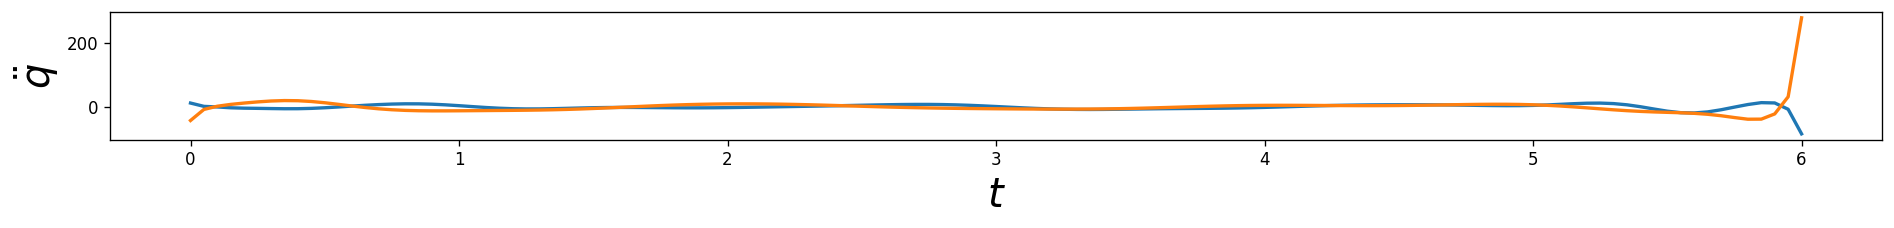

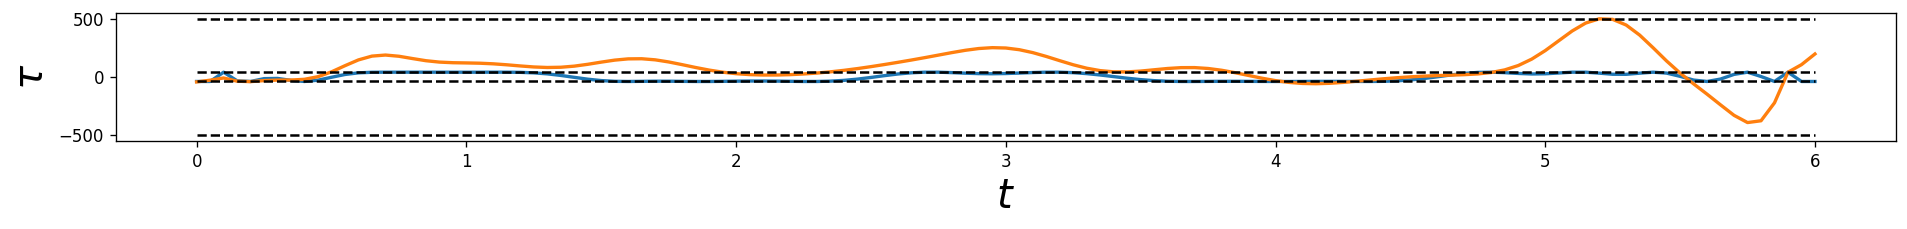

In [7]:
task.plot_q(w_opt)
task.plot_dq(w_opt)
task.plot_ddq(w_opt)
task.plot_tau(w_opt)

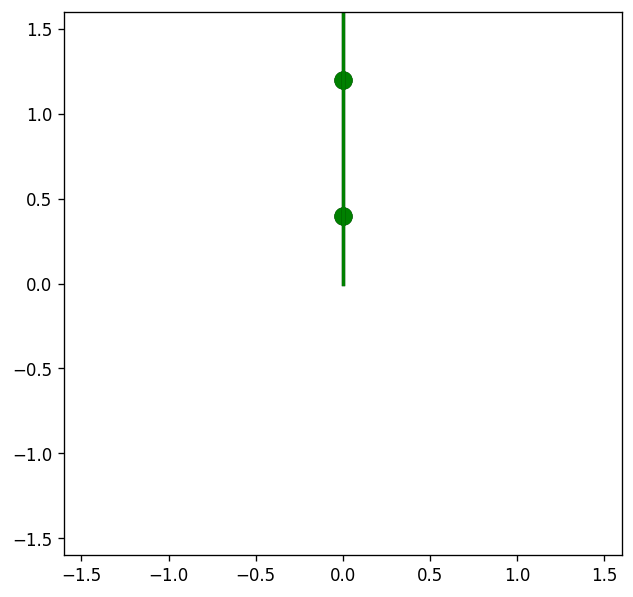

In [9]:
task.save_animation(w_opt)